# Importing modules

In [35]:
!pip3 install emoji
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)
KAGGLE_ENV = os.getcwd == '/kaggle/working'

In [36]:
import io
from google.colab import files

train_tsv = files.upload() 
df = pd.read_csv(io.BytesIO(train_tsv['Tweets.csv'] ))
df = df.reindex(np.random.permutation(df.index))
df = df [['text', 'emotion']]

Saving Tweets.csv to Tweets.csv


# Exploratory Data Analysis

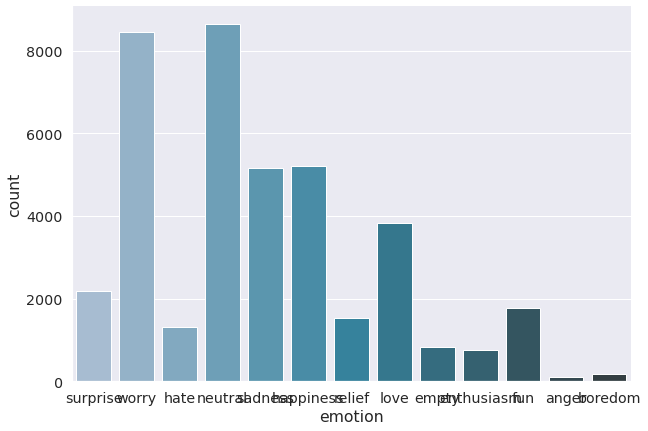

In [37]:
target_dist = sns.factorplot(x="emotion", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

## Text variable
To analyze the text variable, a class **TextCounts** is created. 

* **count_words** : number of words in the tweet
* **count_mentions** : referrals to other Twitter accounts, which are preceded by a @
* **count_hashtags** : number of tag words, preceded by a #
* **count_capital_words** : number of uppercase words, could be used to *"shout"* and express (negative) emotions
* **count_excl_quest_marks** : number of question or exclamation marks
* **count_urls** : number of links in the tweet, preceded by http(s)
* **count_emojis** : number of emoji, which might be a good indication of the emotion

In [38]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [39]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
# Add emotion to df_eda
df_eda['emotion'] = df.emotion

A function **show_dist** that provides descriptive statistics and a plot per target class.

In [40]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('emotion')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='emotion', size=5, hue='emotion', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
   

Descriptive stats for count_words
---------------------------------
             count       mean       std  min   25%   50%    75%   max
emotion                                                              
anger       110.0   14.790909  7.161435  1.0  8.25  15.0  20.75  31.0
boredom     179.0   14.145251  7.125766  2.0  8.00  13.0  20.00  31.0
empty       826.0   12.095642  7.338189  1.0  6.00  11.0  17.00  41.0
enthusiasm  759.0   14.077734  7.317743  2.0  8.00  13.0  20.00  33.0
fun         1776.0  15.130631  6.898365  1.0  9.00  14.0  21.00  33.0
happiness   5209.0  13.981378  7.083374  1.0  8.00  13.0  20.00  35.0
hate        1323.0  15.008314  7.381177  2.0  9.00  15.0  21.00  35.0
love        3842.0  13.932587  7.146212  1.0  8.00  13.0  19.00  34.0
neutral     8638.0  11.969206  7.290208  1.0  6.00  10.0  17.00  46.0
relief      1526.0  14.460682  7.231858  1.0  8.25  14.0  20.00  35.0
sadness     5165.0  14.563214  7.285144  1.0  9.00  14.0  20.00  34.0
surprise    2187.0  14

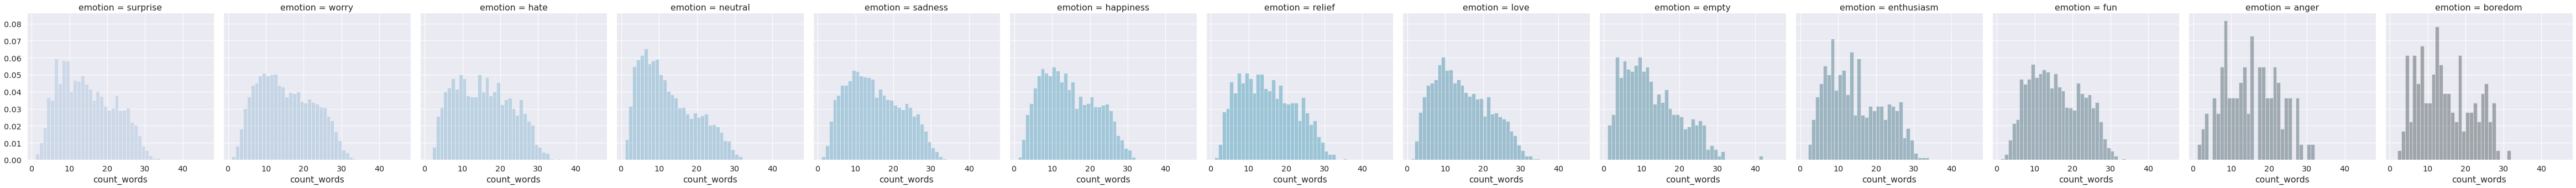

In [41]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
             count      mean       std  min  25%  50%  75%   max
emotion                                                         
anger       110.0   0.454545  0.552498  0.0  0.0  0.0  1.0  2.0 
boredom     179.0   0.284916  0.488458  0.0  0.0  0.0  1.0  3.0 
empty       826.0   0.514528  0.566034  0.0  0.0  0.0  1.0  4.0 
enthusiasm  759.0   0.532279  0.547191  0.0  0.0  1.0  1.0  3.0 
fun         1776.0  0.582770  0.579379  0.0  0.0  1.0  1.0  5.0 
happiness   5209.0  0.516990  0.558888  0.0  0.0  0.0  1.0  4.0 
hate        1323.0  0.390779  0.521089  0.0  0.0  0.0  1.0  3.0 
love        3842.0  0.534617  0.582192  0.0  0.0  1.0  1.0  6.0 
neutral     8638.0  0.558578  0.590129  0.0  0.0  1.0  1.0  10.0
relief      1526.0  0.463958  0.553687  0.0  0.0  0.0  1.0  4.0 
sadness     5165.0  0.423233  0.559201  0.0  0.0  0.0  1.0  7.0 
surprise    2187.0  0.555098  0.565115  0.0  0.0  1.0  1.0  6.0 
worry       8459

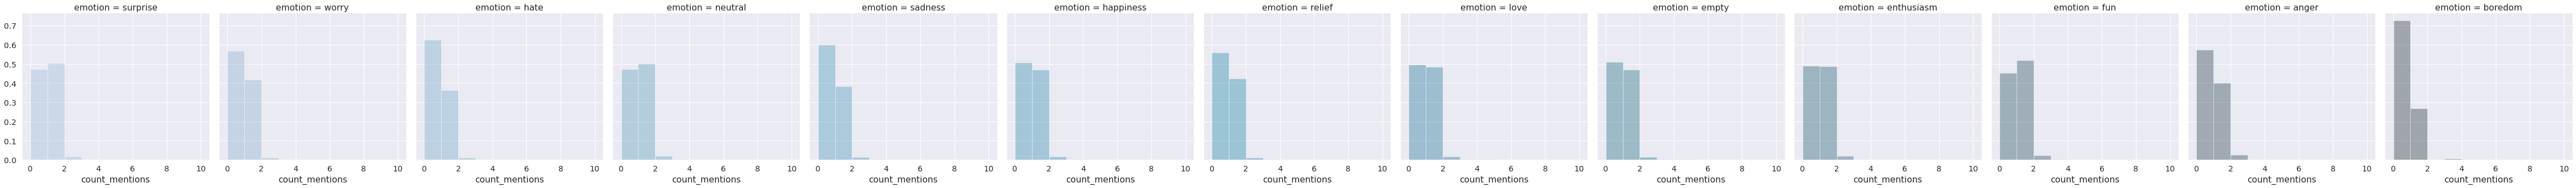

In [42]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
             count      mean       std  min  25%  50%  75%  max
emotion                                                        
anger       110.0   0.027273  0.163622  0.0  0.0  0.0  0.0  1.0
boredom     179.0   0.039106  0.245479  0.0  0.0  0.0  0.0  2.0
empty       826.0   0.010896  0.103876  0.0  0.0  0.0  0.0  1.0
enthusiasm  759.0   0.021080  0.143747  0.0  0.0  0.0  0.0  1.0
fun         1776.0  0.028716  0.203540  0.0  0.0  0.0  0.0  3.0
happiness   5209.0  0.021885  0.161303  0.0  0.0  0.0  0.0  3.0
hate        1323.0  0.020408  0.146696  0.0  0.0  0.0  0.0  2.0
love        3842.0  0.019261  0.174213  0.0  0.0  0.0  0.0  5.0
neutral     8638.0  0.027437  0.254290  0.0  0.0  0.0  0.0  9.0
relief      1526.0  0.020970  0.164624  0.0  0.0  0.0  0.0  3.0
sadness     5165.0  0.022846  0.173420  0.0  0.0  0.0  0.0  3.0
surprise    2187.0  0.026520  0.174366  0.0  0.0  0.0  0.0  3.0
worry       8459.0  0.022698  

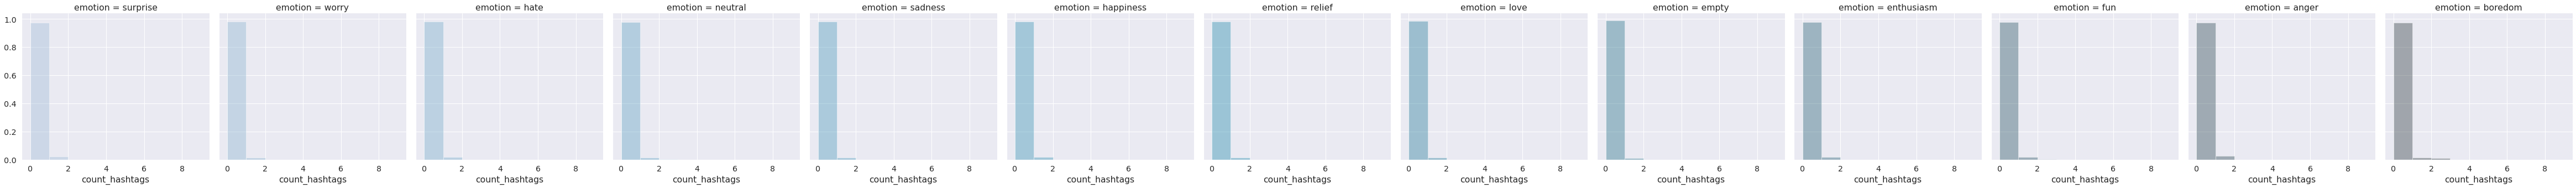

In [43]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
             count      mean       std  min  25%  50%  75%   max
emotion                                                         
anger       110.0   0.318182  1.066004  0.0  0.0  0.0  0.0  9.0 
boredom     179.0   0.296089  1.063456  0.0  0.0  0.0  0.0  12.0
empty       826.0   0.190073  0.800877  0.0  0.0  0.0  0.0  15.0
enthusiasm  759.0   0.355731  1.272788  0.0  0.0  0.0  0.0  21.0
fun         1776.0  0.323761  1.079603  0.0  0.0  0.0  0.0  15.0
happiness   5209.0  0.305241  1.058455  0.0  0.0  0.0  0.0  27.0
hate        1323.0  0.366591  1.569664  0.0  0.0  0.0  0.0  26.0
love        3842.0  0.337585  1.253078  0.0  0.0  0.0  0.0  26.0
neutral     8638.0  0.203519  0.877610  0.0  0.0  0.0  0.0  25.0
relief      1526.0  0.208388  0.748214  0.0  0.0  0.0  0.0  14.0
sadness     5165.0  0.259826  1.163054  0.0  0.0  0.0  0.0  26.0
surprise    2187.0  0.297211  0.985905  0.0  0.0  0.0  0.0  22.0
worry 

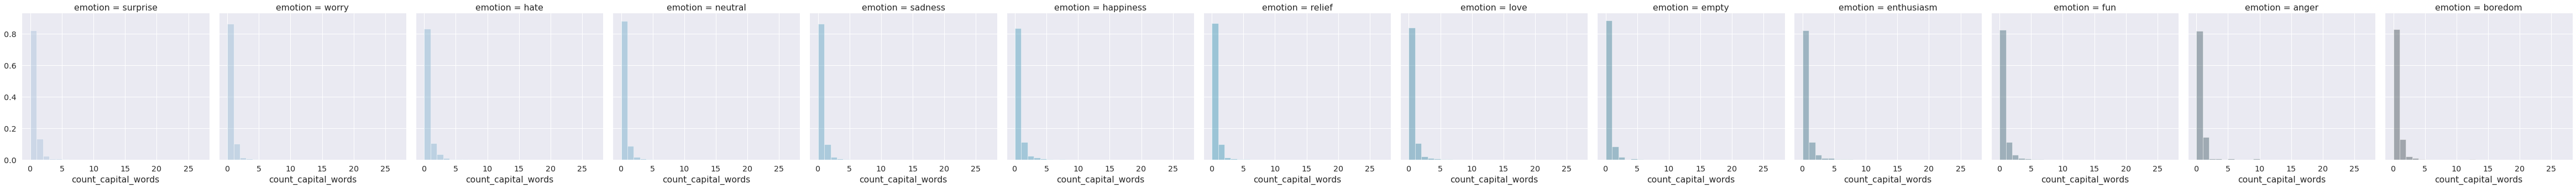

In [44]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
             count      mean       std  min  25%  50%  75%   max
emotion                                                         
anger       110.0   1.027273  1.983691  0.0  0.0  0.0  1.0  12.0
boredom     179.0   0.502793  0.979419  0.0  0.0  0.0  1.0  5.0 
empty       826.0   0.668281  3.688329  0.0  0.0  0.0  1.0  98.0
enthusiasm  759.0   0.898551  1.463356  0.0  0.0  0.0  1.0  17.0
fun         1776.0  0.922860  1.535391  0.0  0.0  0.0  1.0  25.0
happiness   5209.0  0.996160  1.871338  0.0  0.0  0.0  1.0  70.0
hate        1323.0  0.824641  1.918797  0.0  0.0  0.0  1.0  40.0
love        3842.0  0.910203  1.954176  0.0  0.0  0.0  1.0  60.0
neutral     8638.0  0.533457  2.158205  0.0  0.0  0.0  1.0  82.0
relief      1526.0  0.593054  1.066413  0.0  0.0  0.0  1.0  10.0
sadness     5165.0  0.558180  1.265169  0.0  0.0  0.0  1.0  18.0
surprise    2187.0  1.025149  2.270340  0.0  0.0  0.0  1.0  53.0


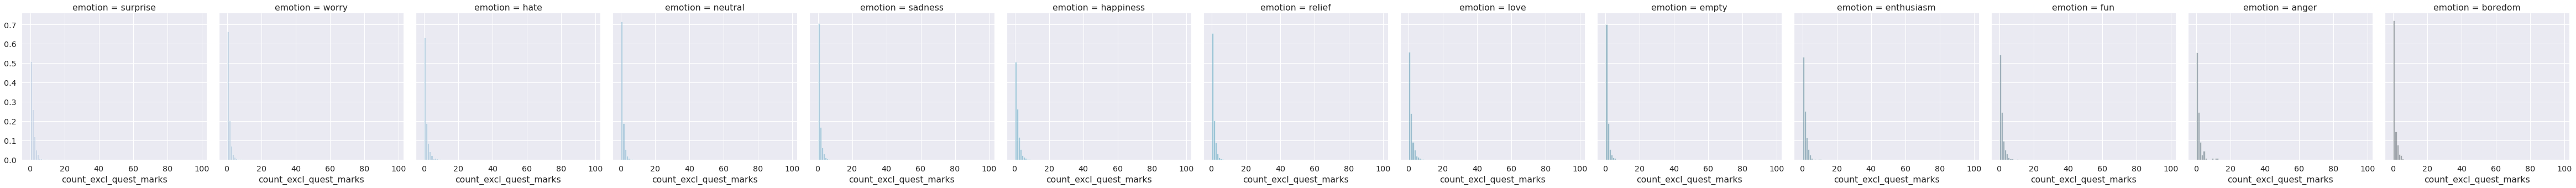

In [45]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
             count      mean       std  min  25%  50%  75%  max
emotion                                                        
anger       110.0   0.036364  0.188050  0.0  0.0  0.0  0.0  1.0
boredom     179.0   0.011173  0.105406  0.0  0.0  0.0  0.0  1.0
empty       826.0   0.059322  0.236370  0.0  0.0  0.0  0.0  1.0
enthusiasm  759.0   0.046113  0.209869  0.0  0.0  0.0  0.0  1.0
fun         1776.0  0.060248  0.238012  0.0  0.0  0.0  0.0  1.0
happiness   5209.0  0.049914  0.223015  0.0  0.0  0.0  0.0  3.0
hate        1323.0  0.028723  0.167089  0.0  0.0  0.0  0.0  1.0
love        3842.0  0.058043  0.236071  0.0  0.0  0.0  0.0  2.0
neutral     8638.0  0.064135  0.252456  0.0  0.0  0.0  0.0  4.0
relief      1526.0  0.033421  0.179791  0.0  0.0  0.0  0.0  1.0
sadness     5165.0  0.028267  0.168072  0.0  0.0  0.0  0.0  2.0
surprise    2187.0  0.046639  0.215207  0.0  0.0  0.0  0.0  2.0
worry       8459.0  0.031328  0.176906

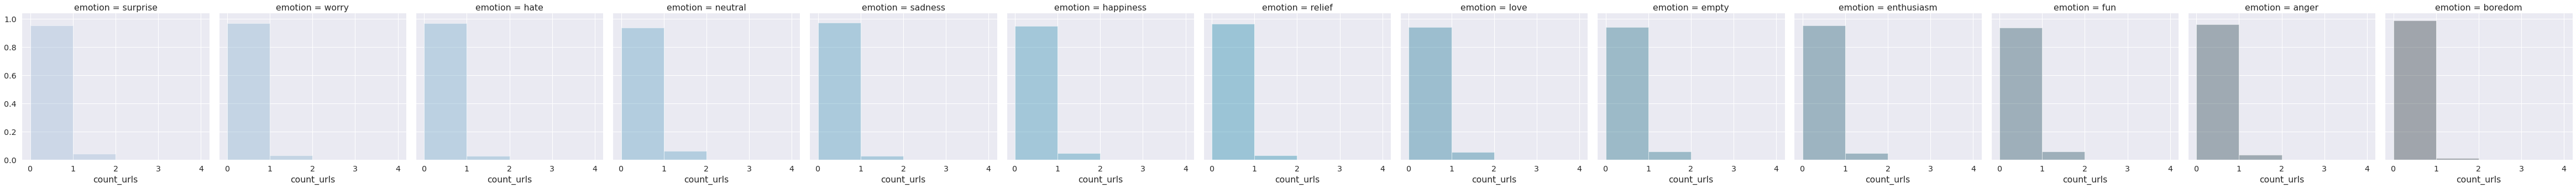

In [46]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
             count      mean       std  min  25%  50%  75%  max
emotion                                                        
anger       110.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
boredom     179.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
empty       826.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
enthusiasm  759.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
fun         1776.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
happiness   5209.0  0.000192  0.013856  0.0  0.0  0.0  0.0  1.0
hate        1323.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
love        3842.0  0.000260  0.016133  0.0  0.0  0.0  0.0  1.0
neutral     8638.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
relief      1526.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
sadness     5165.0  0.000387  0.019676  0.0  0.0  0.0  0.0  1.0
surprise    2187.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
worry       8459.0  0.000355  0.02

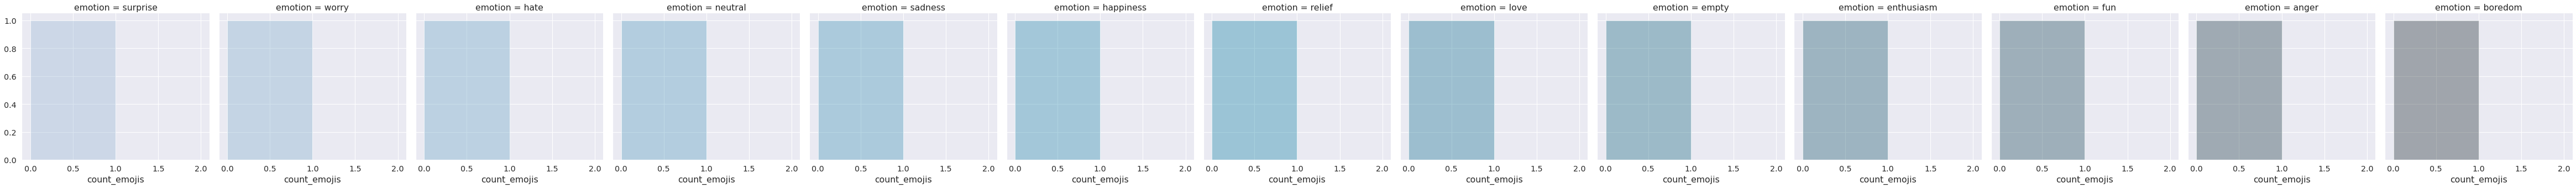

In [47]:
show_dist(df_eda, 'count_emojis')

# Text Cleaning
Before using the tweets' text we should clean it. In the class CleanText:
- remove the **mentions**, 
- remove the **hash tag sign** (#) but not the actual tag as this may contain information
- set all words to **lowercase**
- remove all **punctuations**, including the question and exclamation marks
- remove the **urls** as they do not contain useful information 
- make sure the converted **emojis** are kept as one word. 
- remove **digits**
- remove **stopwords**
- apply the **PorterStemmer** to keep the stem of the words

In [48]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain emotion are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [49]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


19623    quick hello goodby amp enjoy parti tire uk blogger unfortun need sleep beatwittyparti
4373     exhaust                                                                              
15872    never ban court order                                                                
6921     brought back memori mention mixer push angel desk full glass beer not fault desk     
31059    nah look better label top latin name access way no need turn anyth                   
Name: text, dtype: object

In [50]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

219 records have no words left after text cleaning


Now the text of the tweets have been cleaned. Below the top 20 frequent words are shown.

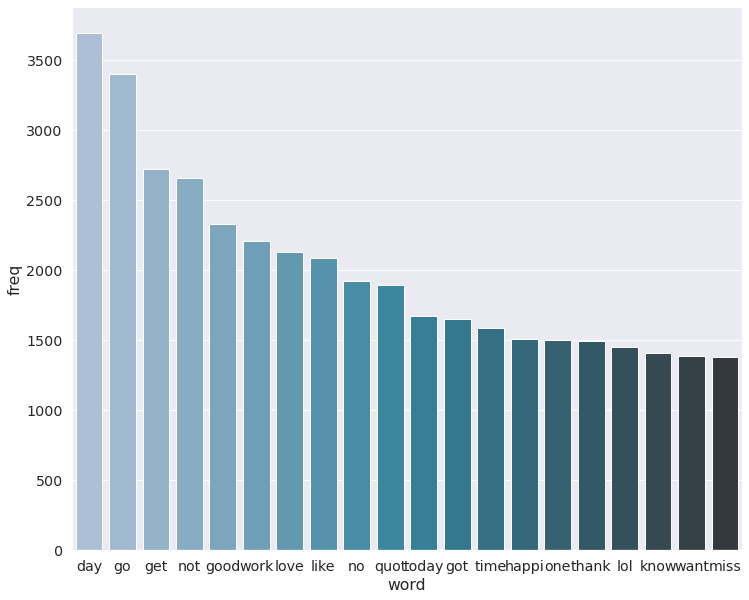

In [51]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();


# Creating test data
To evaluate the trained models we need a **test set**. Evaluating on the train data would not be correct because the models are trained to minimize their cost function. 


In [52]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'emotion',
 'clean_text']

In [53]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('emotion', axis=1), df_model.emotion, test_size=0.1, random_state=37)

## Hyperparameter tuning and cross-validation
Perform **cross-validation**. With cross-validation the data is split into a train and validation set multiple times. The evaluation metric is then averaged over the different folds. 

### Evaluation metrics
By default GridSearchCV uses the default scorer to compute the *best_score_*. For both the MultiNomialNb and LogisticRegression this default scoring metric is the accuracy. 

Other metrics are **precision, recall and F1 score.**

* **Precision: ** Of all rows we predicted to be a certain class, how many did we correctly predict?
* **Recall: ** Of all rows of a certain class, how many did we correctly predict?
* **F1 score: ** Harmonic mean of Precision and Recall.



In [55]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

### Parameter grids for GridSearchCV

In [56]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

## Classifiers
Here compare the performance of a MultinomailNB and LogisticRegression.

In [57]:
mnb = MultinomialNB()
logreg = LogisticRegression()

## CountVectorizer


In [58]:
countvect = CountVectorizer()

In [59]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.6min finished


done in 156.668s

Best CV score: 0.331
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.335


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        15
     boredom       0.00      0.00      0.00        18
       empty       0.00      0.00      0.00        68
  enthusiasm       0.00      0.00      0.00        86
         fun       0.25      0.03      0.05       181
   happiness       0.33      0.40      0.36       529
        hate       0.35      0.04      0.08       137
        love       0.47      0.39      0.43       392
     neutral       0.34      0.46      0.39       845
      relief       0.22      0.01      0.03       143
     sadness       0.33      0.28      0.30       543
    surprise       0.19      0.03      0.05       231
       worry       0.31      0.50 

In [60]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 46.4min finished


done in 2806.458s

Best CV score: 0.350
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.348


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        15
     boredom       0.00      0.00      0.00        18
       empty       0.00      0.00      0.00        68
  enthusiasm       0.00      0.00      0.00        86
         fun       0.28      0.04      0.08       181
   happiness       0.37      0.40      0.38       529
        hate       0.39      0.09      0.14       137
        love       0.53      0.33      0.41       392
     neutral       0.33      0.62      0.43       845
      relief       0.00      0.00      0.00       143
     sadness       0.39      0.27      0.32       543
    surprise       0.50      0.00      0.01       231
       worry     

## TF-IDF


In [61]:
tfidfvect = TfidfVectorizer()

In [62]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.7min finished


done in 161.226s

Best CV score: 0.316
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.318


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        15
     boredom       0.00      0.00      0.00        18
       empty       0.00      0.00      0.00        68
  enthusiasm       0.00      0.00      0.00        86
         fun       0.00      0.00      0.00       181
   happiness       0.31      0.30      0.30       529
        hate       0.00      0.00      0.00       137
        love       0.49      0.23      0.32       392
     neutral       0.33      0.53      0.41       845
      relief       0.00      0.00      0.00       143
     sadness       0.32      0.12      0.17       543
    surprise       0.25      0.00      0.01       231
       worry       0.29      0.63  

In [63]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 47.8min finished


done in 2882.088s

Best CV score: 0.296
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.287


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        15
     boredom       0.00      0.00      0.00        18
       empty       0.00      0.00      0.00        68
  enthusiasm       0.00      0.00      0.00        86
         fun       0.00      0.00      0.00       181
   happiness       0.33      0.08      0.13       529
        hate       1.00      0.01      0.01       137
        love       0.58      0.17      0.26       392
     neutral       0.30      0.63      0.41       845
      relief       0.00      0.00      0.00       143
     sadness       0.41      0.02      0.04       543
    surprise       0.00      0.00      0.00       231
       worry     

## Word2Vec

In [64]:
SIZE = 25

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=3
                 , workers=4)

In [65]:
model.most_similar('plane', topn=3)

[('prepar', 0.9979371428489685),
 ('sit', 0.9976764917373657),
 ('break', 0.9975284934043884)]

In [66]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [67]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [ ]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [69]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.3s finished


done in 60.193s

Best CV score: 0.285
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
Test score with best_estimator_: 0.283


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        15
     boredom       0.00      0.00      0.00        18
       empty       0.00      0.00      0.00        68
  enthusiasm       0.00      0.00      0.00        86
         fun       0.00      0.00      0.00       181
   happiness       0.28      0.14      0.18       529
        hate       0.00      0.00      0.00       137
        love       0.42      0.21      0.28       392
     neutral       0.31      0.57      0.40       845
      relief       0.00      0.00      0.00       143
     sadness       0.36      0.02      0.03       543
    surprise       0.00      0.00      0.00       231
       worry       0.25      0.60      0.35       812

    accuracy                           0.28      4000
   macro avg       0.12

## Conclusion


* Both classifiers achieve the best results when using the features of the CountVectorizer


* Overall, LogisticRegression outperforms the Multinomial Naive Bayes classifier

* The best performance on the test set comes from the LogisticRegression with features from CountVectorizer.





